# Least cost approach to unbalanced barycenters

## Loading and libraries and defining helper functions

In [1]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

from scipy.optimize import minimize_scalar

In [2]:
# adapt POT functions to suit our needs
def gauss_1d_pdf(x, m, s):
    h = np.exp(-(x - m) ** 2 / (2 * s ** 2))
    return h / h.sum()

from matplotlib import gridspec

def plot1D_mat_with_x(x,a, b, M, title=''):
    r""" Plot matrix :math:`\mathbf{M}`  with the source and target 1D distribution

    Creates a subplot with the source distribution :math:`\mathbf{a}` on the left and
    target distribution :math:`\mathbf{b}` on the top. The matrix :math:`\mathbf{M}` is shown in between.


    Parameters
    ----------
    x : location of points
    a : ndarray, shape (na,)
        Source distribution
    b : ndarray, shape (nb,)
        Target distribution
    M : ndarray, shape (na, nb)
        Matrix to plot
    """
    na, nb = M.shape

    gs = gridspec.GridSpec(3, 3)

    #xa = np.arange(na)
    #xb = np.arange(nb)

    ax1 = pl.subplot(gs[0, 1:])
    pl.plot(x, b, 'r', label='Target distribution')
    pl.yticks(())
    pl.title(title)

    ax2 = pl.subplot(gs[1:, 0])
    pl.plot(a, x, 'b', label='Source distribution')
    pl.gca().invert_xaxis()
    pl.gca().invert_yaxis()
    pl.xticks(())

    pl.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    pl.imshow(M, extent = (x.min(), x.max(), x.min(), x.max()), interpolation='nearest')
    pl.axis('off')

    pl.xlim((x.min(), x.max()))
    pl.ylim((x.min(), x.max()))
    pl.tight_layout()
    pl.subplots_adjust(wspace=0., hspace=0.2)
    
# simple barycenter histogram calculator based on the mapping T, bins x and optimal plan matrix G
def compute_bary(T,x,G):
    N = len(x)
    barycenter_histogram  = np.zeros(N)
    for i in range(N):
        for j in range(N):
            II = np.argmin(abs(T[i,j] - x))
            barycenter_histogram[II] += G[j,i] 
    return barycenter_histogram

In [3]:
# HK cost function
def c_full_HK(x,x1,x2,l1,l2):
    return -np.log((np.cos(abs(x-x1))**(2*l1))*(np.cos(abs(x-x2))**(2*l2)))

# quadratic cost (of course no real need to find the minimum numerically)
def c_full_quad(x,x1,x2,l1,l2):
    return l1*abs(x-x1)**2 + l2*(abs(x-x2))**2


In [4]:
def c_tilde_HK(x1,x2,l1,l2):
    if abs(x1-x2) > np.pi - 1e-5:
        return 50.0
    else:
        x_l = max(x1,x2) - np.pi/2 + 1e-6
        x_r = min(x1,x2) + np.pi/2 - 1e-6
        f = lambda x : c_full_HK(x,x1,x2,l1,l2)
        res = minimize_scalar(f,bounds=(x_l, x_r), method='bounded')
        return res.fun, res.x
    
def c_tilde_quad(x1,x2,l1,l2):
    x_l = min(x1,x2)
    x_r = max(x1,x2)
    f = lambda x : c_full_quad(x,x1,x2,l1,l2)
    res = minimize_scalar(f,bounds=(x_l, x_r), method='bounded')
    return res.fun, res.x

In [5]:
# define empirical measures approximating two unbalanced Gaussians

n = 200  # nb bins

# bin positions
x = np.linspace(0,1,num=n,dtype=np.float64)

# Gaussian distributions
a = gauss_1d_pdf(x, m=0.2, s=0.05)  # m= mean, s= std
b = gauss_1d_pdf(x, m=0.8, s=0.08)

# make distributions unbalanced
b *= 2.

# # loss matrix
# M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
# M /= M.max()

In [6]:
# define lambdas
l1 = 0.83
l2 = 1.0-l1

# compute cost matrices 
M_HK = np.array([[c_tilde_HK(xx,yy,l1,l2)[0] for xx in x] for yy in x])
M_quad = np.array([[c_tilde_quad(xx,yy,l1,l2)[0] for xx in x] for yy in x])

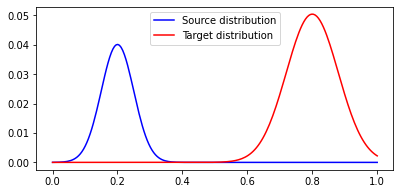

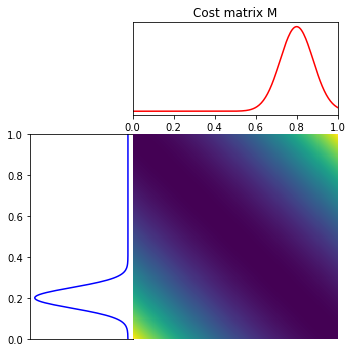

In [7]:
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

# plot distributions and loss matrix

pl.figure(2, figsize=(5, 5))
plot1D_mat_with_x(x,a, b, M_HK, 'Cost matrix M')

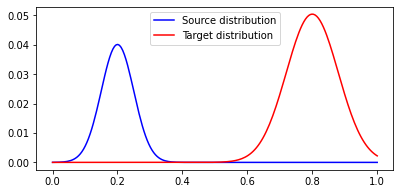

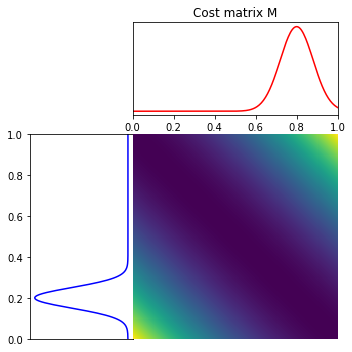

In [8]:
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source distribution')
pl.plot(x, b, 'r', label='Target distribution')
pl.legend()

# plot distributions and loss matrix

pl.figure(2, figsize=(5, 5))
plot1D_mat_with_x(x,a, b, M_quad, 'Cost matrix M')

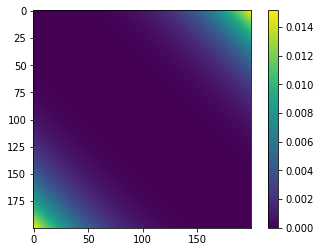

In [9]:
# confirm the two cost matrices are very similar:

pl.imshow(abs(M_HK - M_quad))
pl.colorbar()

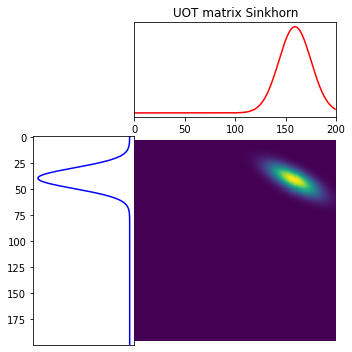

In [10]:
# Sinkhorn for least HK cost


epsilon = 0.0009  # entropy parameter
reg_m=(l1,l2)  # Unbalanced KL relaxation parameter
Gs_HK = ot.unbalanced.sinkhorn_unbalanced(a, b, M_HK, epsilon, reg_m, verbose=True)

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs_HK, 'UOT matrix Sinkhorn')

pl.show()

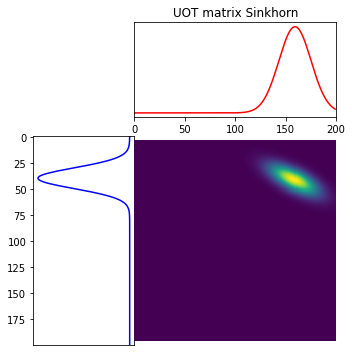

In [11]:
# Sinkhorn for least quadratic cost

epsilon = 0.0009 # entropy parameter
reg_m=(l1,l2)  # Unbalanced KL relaxation parameter
Gs_quad = ot.unbalanced.sinkhorn_unbalanced(a, b, M_quad, epsilon, reg_m, verbose=True)

pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs_quad, 'UOT matrix Sinkhorn')

pl.show()

In [12]:
T_HK = np.array([[c_tilde_HK(xx,yy,l1,l2)[1] for xx in x] for yy in x])
T_quad = np.array([[c_tilde_quad(xx,yy,l1,l2)[1] for xx in x] for yy in x])

bary_HK = compute_bary(T_HK,x,Gs_HK)
bary_quad = compute_bary(T_quad,x,Gs_quad)

In [13]:
pl.rcParams.update({'font.size': 20})

Text(0.5, 1.0, 'Least cost constrained HK barycenter, $\\lambda_1 = 0.83$')

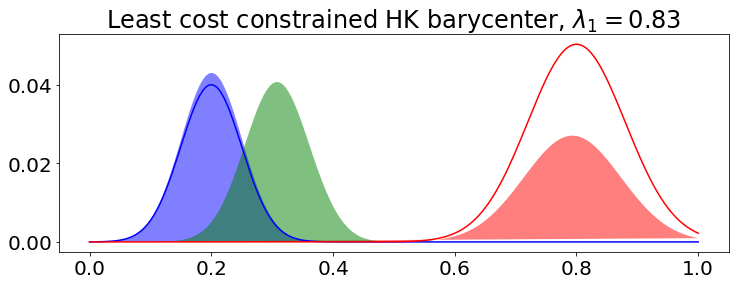

In [14]:
pl.figure(4, figsize=(12, 4))
pl.plot(x, a, 'b', label=r'Input measure $\mu_1$')
pl.plot(x, b, 'r', label=r'Input measure $\mu_2$')
pl.fill(x, Gs_HK.sum(1), 'b', alpha=0.5, label=r'Marginal $\bar \gamma_1$')
pl.fill(x, Gs_HK.sum(0), 'r', alpha=0.5, label=r'Marginal $\bar \gamma_2$')
pl.fill(x, bary_HK, 'g', alpha=0.5, label=r'Barycenter $\bar \nu$')
#pl.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
pl.title(r'Least cost constrained HK barycenter, $\lambda_1 = {0}$'.format(l1))

Text(0.5, 1.0, 'Least cost unbalanced barycenter with quadratic cost, $\\lambda_1 = 0.83$')

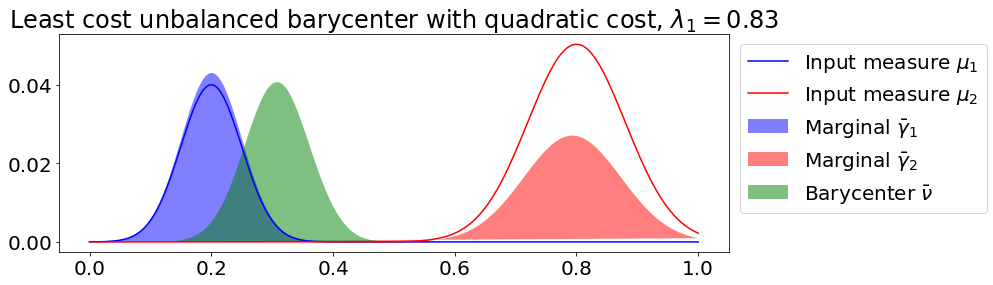

In [15]:
pl.figure(4, figsize=(12, 4))
pl.plot(x, a, 'b', label=r'Input measure $\mu_1$')
pl.plot(x, b, 'r', label=r'Input measure $\mu_2$')
pl.fill(x, Gs_HK.sum(1), 'b', alpha=0.5, label=r'Marginal $\bar \gamma_1$')
pl.fill(x, Gs_HK.sum(0), 'r', alpha=0.5, label=r'Marginal $\bar \gamma_2$')
pl.fill(x, bary_HK, 'g', alpha=0.5, label=r'Barycenter $\bar \nu$')
pl.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
pl.title(r'Least cost unbalanced barycenter with quadratic cost, $\lambda_1 = {0}$'.format(l1))

In [16]:
# simple calculations to confirm mass creation/annihilation
print("Mass of mu_1: ", a.sum())
print("Mass of mu_2: ", b.sum())

print("Mass of optimal plan with HK cost: ", Gs_HK.sum())
print("Mass of optimal plan with quadratic cost: ", Gs_quad.sum())

Mass of mu_1:  1.0
Mass of mu_2:  1.9999999999999998
Mass of optimal plan with HK cost:  1.0756900136511875
Mass of optimal plan with quadratic cost:  1.0776686023904198


In [17]:
pl.rcParams['mathtext.fontset'] = 'stix'
pl.rcParams['font.family'] = 'STIXGeneral'

In [18]:
pl.rcParams.update({'font.size': 36})

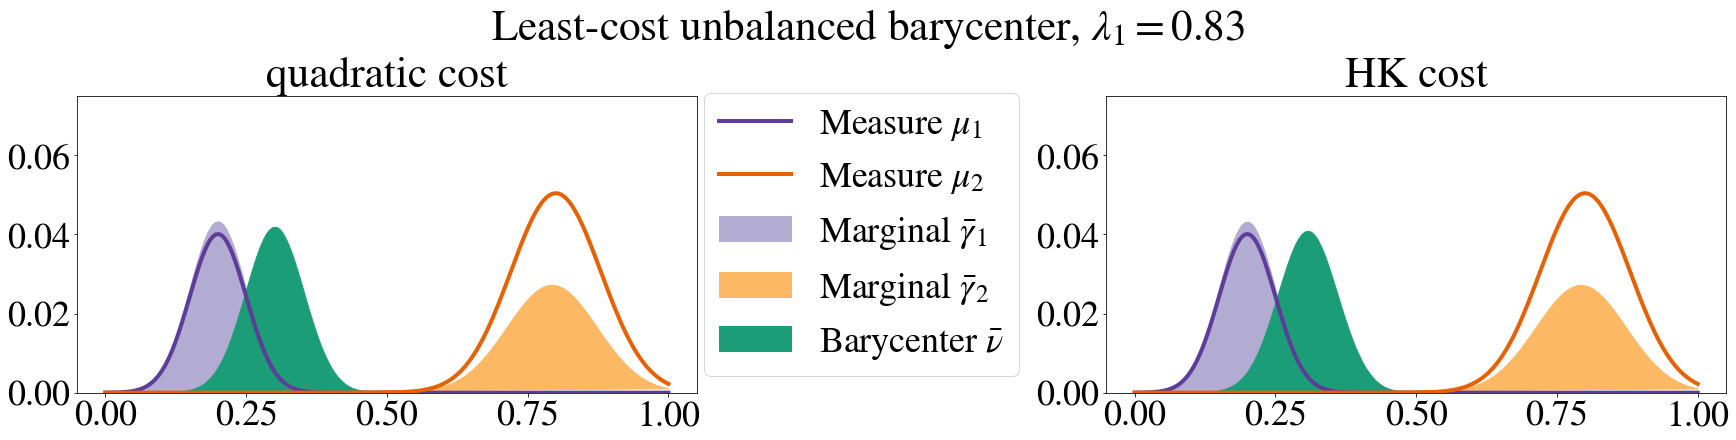

In [19]:
# nice plot for the paper

fig, (ax1, ax2) = pl.subplots(1, 2,figsize=(24, 6), constrained_layout=True)
fig.suptitle(r'Least-cost unbalanced barycenter, $\lambda_1 = {0:.2f}$'.format(l1)) 
ax1.plot(x, a,color = (94/255,60/255,153/255), label=r'Measure $\mu_1$',lw = 4)
ax1.plot(x, b, color=(230/255,97/255,1/255), label=r'Measure $\mu_2$',lw=4)
ax1.fill(x, Gs_quad.sum(1), color=(178/255,171/255,210/255), alpha=1.0, label=r'Marginal $\bar \gamma_1$')
ax1.fill(x, Gs_quad.sum(0), color = (253/255,184/255,99/255), alpha=1.0, label=r'Marginal $\bar \gamma_2$')
ax1.fill(x, bary_quad, color = (27/255,158/255,119/255), alpha=1.0, label=r'Barycenter $\bar \nu$')
ax1.legend(loc='upper right', bbox_to_anchor=(1.55, 1.07))
ax1.set_title(r'quadratic cost')
ax1.set_ylim(0.0,0.075)

ax2.set_title(r'HK cost')

ax2.plot(x, a, color = (94/255,60/255,153/255), label=r'Measure $\mu_1$',lw = 4)
ax2.plot(x, b, color=(230/255,97/255,1/255), label=r'Measure $\mu_2$',lw=4)
ax2.fill(x, Gs_HK.sum(1), color=(178/255,171/255,210/255), alpha=1.0, label=r'Marginal $\bar \gamma_1$')
ax2.fill(x, Gs_HK.sum(0), color = (253/255,184/255,99/255), alpha=1.0, label=r'Marginal $\bar \gamma_2$')
ax2.fill(x, bary_HK, color = (27/255,158/255,119/255), alpha=1.0, label=r'Barycenter $\bar \nu$')
ax2.set_ylim(0.0,0.075)
fig.savefig(f'l1_{l1}.pdf') 

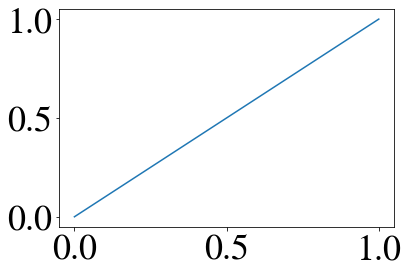

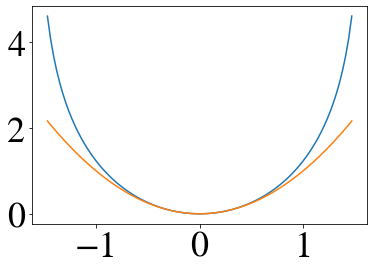

In [29]:
xx = np.linspace(-np.pi/2 + 1e-1,np.pi/2 - 1e-1,num=100)
y1 = -np.log(np.cos(abs(xx))**2)
y2 = xx**2
pl.plot(xx,y1)
pl.plot(xx,y2)